# Connecting Rods

### Original mage

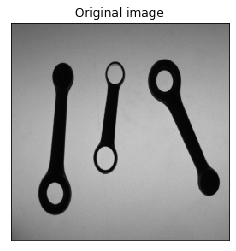

In [498]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
plt.figure(figsize=(4,4))

original_img = cv.imread('testImages/TESI01.BMP',0)
img = original_img.copy()
plt.imshow(img, cmap='gray',vmin=0,vmax=255)
plt.title('Original image'), plt.xticks([]), plt.yticks([])
plt.show()

### Apply Otsu's tresholding

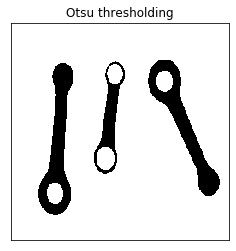

In [499]:
plt.figure(figsize=(4,4))

ret, imgf = cv.threshold(img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(imgf,cmap = 'gray')
plt.title('Otsu thresholding'), plt.xticks([]), plt.yticks([])
plt.show()

### Apply closing operation

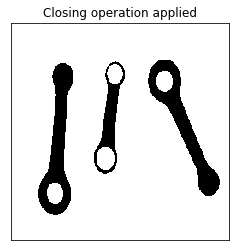

In [500]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(1,1))
closing = cv.morphologyEx(imgf, cv.MORPH_CLOSE, kernel)
plt.imshow(closing,cmap = 'gray')
plt.title('Closing operation applied'), plt.xticks([]), plt.yticks([])
plt.show()

### Labeling rods

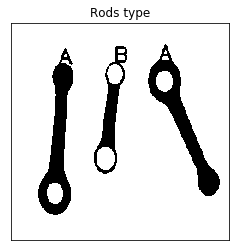

In [501]:
img, contours, hierarchy = cv.findContours(closing.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
for i in range(hierarchy.shape[1]):
    if hierarchy[0, i][3] == 0:
        if len(hierarchy[:, np.where(hierarchy[0][:, 3] == i)][0][0]) == 1:
            img = cv.putText(img, 'A', (contours[i][0][0][0], contours[i][0][0][1]), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv.LINE_4)
            plt.imshow(img,cmap = 'gray')
            plt.title('Rods type'), plt.xticks([]), plt.yticks([])
        elif len(hierarchy[:, np.where(hierarchy[0][:, 3] == i)][0][0]) > 1:
            img = cv.putText(img, 'B', (contours[i][0][0][0], contours[i][0][0][1]), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv.LINE_4)
            plt.imshow(img,cmap = 'gray')
            plt.title('Rods type'), plt.xticks([]), plt.yticks([])
            
plt.show()

## Position and orientation 

In [502]:
img = original_img.copy()
#(x,y),(MA,ma),angle = cv.fitEllipse(contours[3])

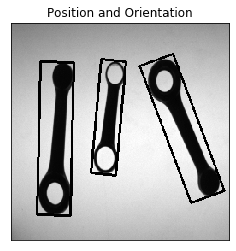

In [503]:
for i in range(hierarchy.shape[1]):
    if hierarchy[0, i][3] == 0:
        rect = cv.minAreaRect(contours[i])
        box = cv.boxPoints(rect)
        box = np.int0(box)
        img = cv.drawContours(img,[box],0,(0,0,255),2)
        plt.imshow(img, cmap = 'gray')
        plt.title('Position and Orientation'), plt.xticks([]), plt.yticks([])
plt.show()